Arquitectura

https://medium.com/x8-the-ai-community/audio-classification-using-cnn-coding-example-f9cbd272269e

In [36]:
import sys
sys.executable

'/home/julian/anaconda3/envs/py3/bin/python3'

In [37]:
! python -c 'import tensorflow as tf; print(tf.__version__)'

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'tensorflow'


In [38]:
import numpy as np
import pandas as pd
import warnings; warnings.simplefilter('ignore')
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Conv2D,Dropout,Flatten,MaxPooling2D, Input
from tensorflow.keras import optimizers
from tensorflow.keras import utils
from sklearn.metrics import confusion_matrix

In [39]:
path = '../../data/spectrograms/spectrograms_5000.hd5'

In [40]:
df = pd.read_hdf(path)

In [41]:
test_size = 0.2

### Reshape images add channel

In [42]:
width=df.Spectrogram[0].shape[1]
high=df.Spectrogram[0].shape[0]
images_number = len(df)

In [43]:
images_dimensions =(1,high,width)
images_dimensions

(1, 99, 161)

In [44]:
x_shape = (images_number,high,width) 

In [45]:
d = np.zeros(x_shape)
cont_images = 0
for i in df['Spectrogram'].values:
    i.reshape(images_dimensions)
    d[cont_images,:,:]=i
    cont_images =cont_images +1

In [46]:
d.shape ## matriz con las imagenes 

(5000, 99, 161)

# Dataset

In [47]:
X = d
Y = df.word.values
print('Tamaño dataSet', X.shape)
print('\n')
Y = np.reshape(Y,(np.size(Y,0),1))
print('Y shape',Y.shape)
groups = df.speaker.values

Tamaño dataSet (5000, 99, 161)


Y shape (5000, 1)


## Data Split

In [48]:
def splitDataSet(X,Y,groups,test_size):              
        gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=0)
        gss.get_n_splits()
        returns = []
        for train_index, test_index in gss.split(X, Y, groups=groups):
            X_train_original, X_test_original = X[train_index], X[test_index]
            Y_train__original, Y_test_original = Y[train_index], Y[test_index]
            groups_original = groups[train_index]
            groups_test_original=groups[test_index]
            returns.append(X_train_original)
            returns.append(Y_train__original)
            returns.append(X_test_original)
            returns.append(Y_test_original)
            returns.append(groups_original)
            returns.append(groups_test_original) 
              
        return returns

In [49]:
data_train = splitDataSet(X,Y,groups,test_size)
X_train_original = data_train[0]
Y_train__original=data_train[1]
X_test_original=data_train[2]
Y_test_original=data_train[3]
groups_original=data_train[4]
groups_test_original=data_train[5]

In [50]:
X_train_original.shape

(4111, 99, 161)

In [51]:
Y_test_original.shape

(889, 1)

# Expandir dimensiones de X 

In [52]:
X_train_original= np.expand_dims(X_train_original, axis=3)
X_test_original= np.expand_dims(X_test_original, axis=3)

In [53]:
X_train_original.shape

(4111, 99, 161, 1)

In [54]:
X_test_original.shape

(889, 99, 161, 1)

# One-hot

In [55]:
y_trainOHE = utils.to_categorical(Y_train__original)
y_trainOHE

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [56]:
### Número de clases
num_classes = y_trainOHE.shape[1]

In [57]:
input_shape =(high,width,1)

In [58]:
input_shape

(99, 161, 1)

In [59]:
num_classes

5

## Define the network architecture using keras

In [60]:
model = Sequential()

img= Input(shape=input_shape)

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

validity = model(img)

Model(img, validity)

# loss function and optimizer

In [61]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 97, 159, 32)       320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 95, 157, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 78, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 47, 78, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 234624)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               30032000  
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

# Training

In [62]:
print("Training...")
history = model.fit(X_train_original, y_trainOHE, epochs=80, batch_size=80, validation_split=0.1, verbose=1)

Training...
Train on 3699 samples, validate on 412 samples
Epoch 1/80
3699/3699 [==============================] - 76s 21ms/sample - loss: 27.7553 - accuracy: 0.2493 - val_loss: 2.2638 - val_accuracy: 0.0000e+00
Epoch 2/80
3699/3699 [==============================] - 77s 21ms/sample - loss: 1.5828 - accuracy: 0.2422 - val_loss: 1.6639 - val_accuracy: 0.0000e+00
Epoch 3/80
3699/3699 [==============================] - 73s 20ms/sample - loss: 1.5991 - accuracy: 0.2260 - val_loss: 1.7788 - val_accuracy: 0.0000e+00
Epoch 4/80
3699/3699 [==============================] - 78s 21ms/sample - loss: 1.5913 - accuracy: 0.2233 - val_loss: 1.8941 - val_accuracy: 0.0000e+00
Epoch 5/80
3699/3699 [==============================] - 78s 21ms/sample - loss: 1.5792 - accuracy: 0.2217 - val_loss: 2.2639 - val_accuracy: 0.0000e+00
Epoch 6/80
3699/3699 [==============================] - 80s 22ms/sample - loss: 1.5660 - accuracy: 0.2411 - val_loss: 2.0296 - val_accuracy: 0.0000e+00
Epoch 7/80
3699/3699 [======

3699/3699 [==============================] - 73s 20ms/sample - loss: 0.2697 - accuracy: 0.9008 - val_loss: 2.1086 - val_accuracy: 0.4927
Epoch 56/80
3699/3699 [==============================] - 80s 22ms/sample - loss: 0.2667 - accuracy: 0.9046 - val_loss: 2.2013 - val_accuracy: 0.4272
Epoch 57/80
3699/3699 [==============================] - 75s 20ms/sample - loss: 0.2710 - accuracy: 0.9005 - val_loss: 2.3666 - val_accuracy: 0.5291
Epoch 58/80
3699/3699 [==============================] - 71s 19ms/sample - loss: 0.2498 - accuracy: 0.9065 - val_loss: 2.4150 - val_accuracy: 0.4854
Epoch 59/80
3699/3699 [==============================] - 70s 19ms/sample - loss: 0.2265 - accuracy: 0.9208 - val_loss: 2.8836 - val_accuracy: 0.4272
Epoch 60/80
3699/3699 [==============================] - 71s 19ms/sample - loss: 0.2696 - accuracy: 0.9043 - val_loss: 1.9202 - val_accuracy: 0.5049
Epoch 61/80
3699/3699 [==============================] - 71s 19ms/sample - loss: 0.2471 - accuracy: 0.9111 - val_loss:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


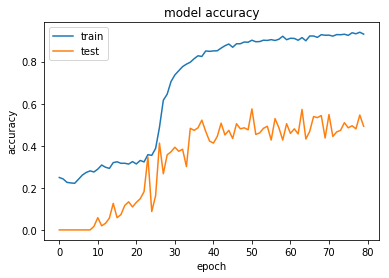

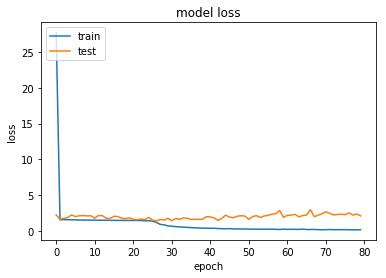

In [63]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Predict

In [64]:
def predict(model,X_test_original):
    Yest = model.predict(X_test_original)
    Yest = np.argmax(Yest, axis=1)
    Yest = Yest.reshape((Yest.shape[0],1))
    return Yest

In [65]:
def consfusion_matrix(Y_real,preds,nb_classes):
    Accuracy = np.mean(preds == Y_real)
    print('Accuracy = ', Accuracy*100, '% ')
    objects = ('yes','no','right','five','nine')
    cm = confusion_matrix(Y_real, preds)
    cm = cm/np.sum(cm,axis=0)
    cmap = plt.cm.gray
    tick_marks = np.arange(nb_classes)
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = ax.text(j, i, np.around(cm[i, j],decimals=2),
                           ha="center", va="center", color="w")
    plt.title('Normalized confusion matrix')
    fig.colorbar(im)
    plt.xticks(tick_marks, objects, rotation=45)
    plt.yticks(tick_marks, objects);

Accuracy =  78.62767154105737 % 


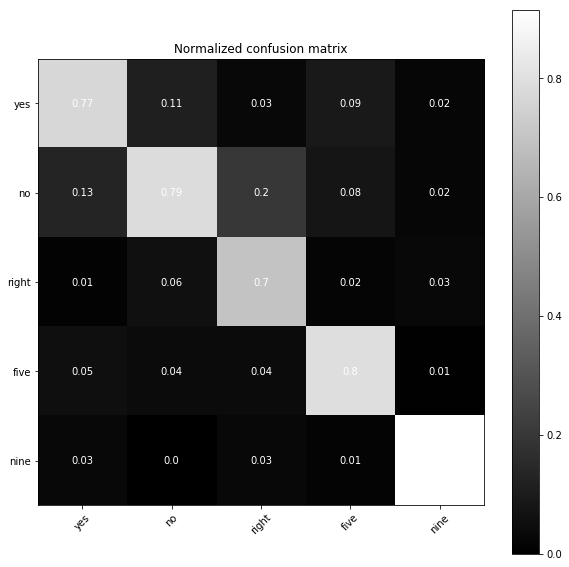

In [66]:
Yest  = predict(model,X_test_original)
Yest =Yest.flatten()
Yest =np.array(Yest)
Y_test_original= Y_test_original.flatten()
Y_test_original =list(Y_test_original)
consfusion_matrix(Y_test_original,Yest,5)

In [ ]:
path_model_Save = '/home/josearangos/Documentos/Projects/Voice_Recognition/pipelines/Enoque_Imagenes_Espectrograma_CNN/models/mode_2500_trained_samples_10_epochs_arquitectura2'

In [ ]:
model.save(path_model_Save)